<a href="https://colab.research.google.com/github/EmiTR/Testprojekt-ET/blob/main/ET_Wasserstein_GAN_NurCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will implement Wasserstein Generative Adversarial Nets (W-GAN) from [Wasserstein GAN](https://https://arxiv.org/pdf/1701.07875.pdf) written by Martin Arjovsky, Soumith Chintala and L´eon Bottou.

The dataset I use for this notebook and for other GAN-notebooks is MNIST (Modified National Institute of Standards and Technology) of handwritten digits in black and white.

To use GPU for this notebook in Colab: Runtime -> Change Runtime Type -> GPU

# Setup

In [1]:
import os
import numpy as np
import math
import sys
from time import time
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

os.makedirs("images", exist_ok=True)

In [2]:
#checking device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
#cuda = True if torch.cuda.is_available() else False

cpu


In [3]:
class Opt(object):
    dim = 10
    n_epochs = 200
    batch_size = dim*dim
    lr = 0.00005
    n_cpu = 1
    latent_dim = 100
    img_size = 28
    channels = 1
    n_critic = 5
    clip_value = 0.01
    sample_interval = 400
opt = Opt()  
img_shape = (opt.channels, opt.img_size, opt.img_size)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(opt.img_size ** 2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [6]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if device == "cuda":
    generator.cuda()
    discriminator.cuda()

In [7]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



In [9]:
# Optimizers
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if device == "cuda" else torch.FloatTensor


In [10]:
# ----------
#  Training
# ----------

batches_done = 0
saved_imgs = []
for epoch in range(opt.n_epochs):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = Variable(imgs.type(Tensor))
        # train Discriminator
        discriminator_optimizer.zero_grad()
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        # generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        discriminator_loss = torch.mean(discriminator(fake_imgs)) - torch.mean(discriminator(real_imgs)) 
        discriminator_loss.backward()
        discriminator_optimizer.step()
        # clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)
        # train the generator every n_critic iterations
        if i % opt.n_critic == 0:
            # train Generator
            generator_optimizer.zero_grad()
            # generate a batch of fake images
            critics_fake_imgs = generator(z)
            # Adversarial loss
            generator_loss = -torch.mean(discriminator(critics_fake_imgs))
            generator_loss.backward()
            generator_optimizer.step()
        batches_done += 1
    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)
    grid = torchvision.utils.make_grid(critics_fake_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)


Epoch 0 training... done, took 24.6 seconds.
Epoch 1 training... done, took 25.1 seconds.
Epoch 2 training... done, took 24.9 seconds.
Epoch 3 training... done, took 24.6 seconds.
Epoch 4 training... done, took 24.5 seconds.
Epoch 5 training... done, took 24.4 seconds.
Epoch 6 training... done, took 24.3 seconds.
Epoch 7 training... done, took 24.2 seconds.
Epoch 8 training... done, took 24.3 seconds.
Epoch 9 training... done, took 24.2 seconds.
Epoch 10 training... done, took 24.3 seconds.
Epoch 11 training... done, took 24.2 seconds.
Epoch 12 training... done, took 24.1 seconds.
Epoch 13 training... done, took 24.2 seconds.
Epoch 14 training... done, took 24.2 seconds.
Epoch 15 training... done, took 24.1 seconds.
Epoch 16 training... done, took 24.2 seconds.
Epoch 17 training... done, took 24.1 seconds.
Epoch 18 training... done, took 24.2 seconds.
Epoch 19 training... done, took 24.3 seconds.
Epoch 20 training... done, took 24.2 seconds.
Epoch 21 training... done, took 24.2 seconds

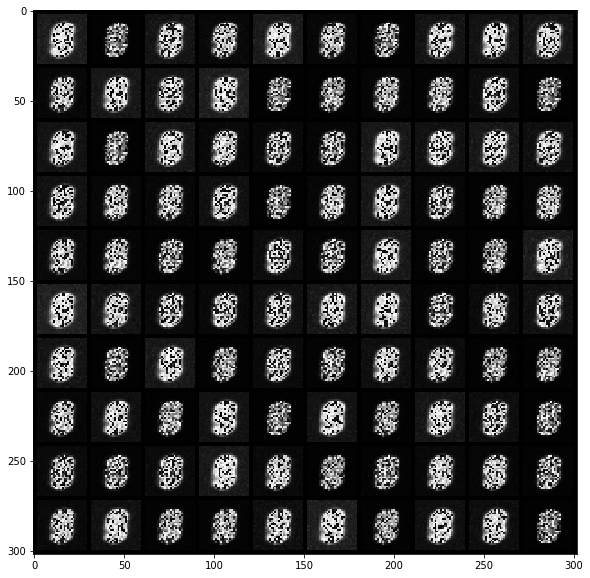

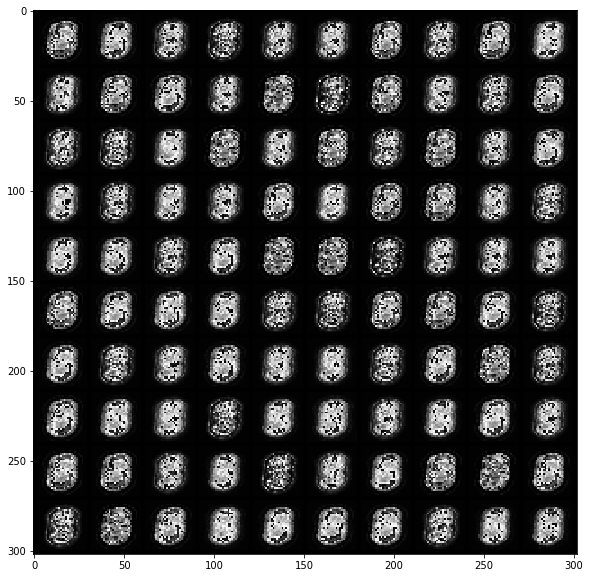

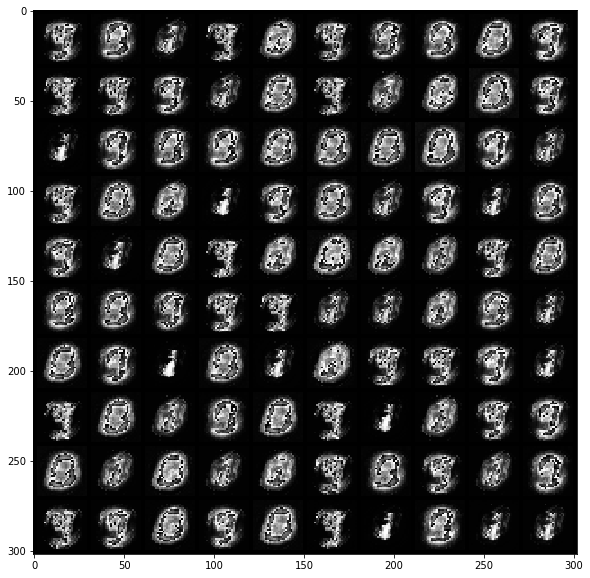

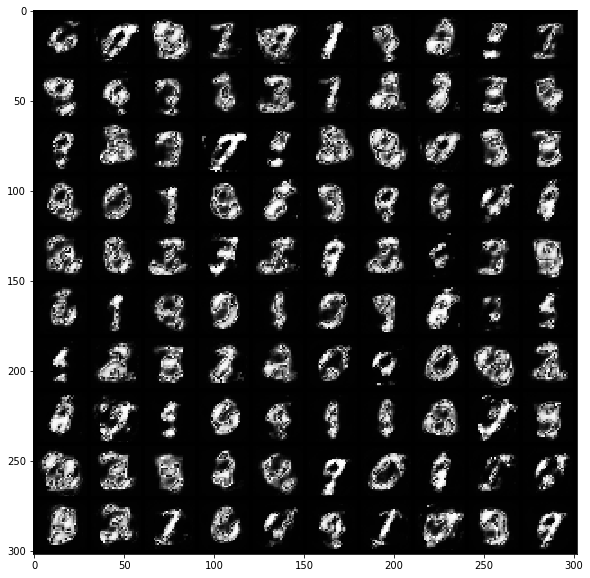

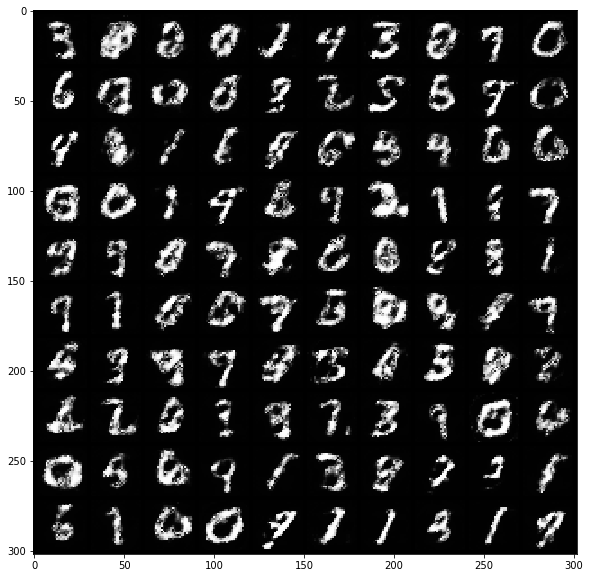

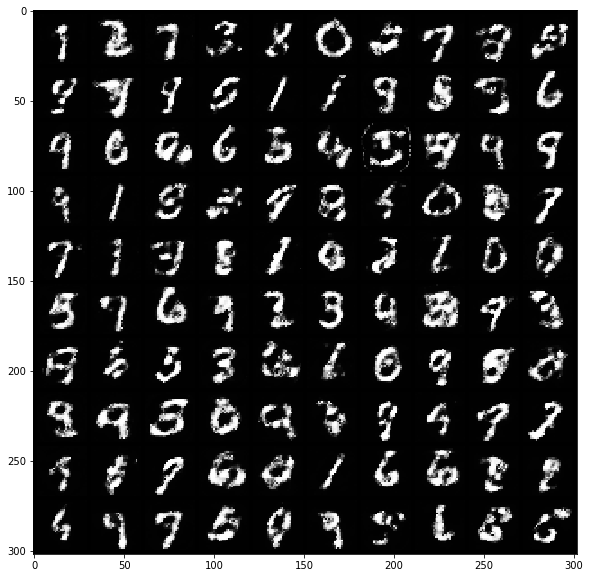

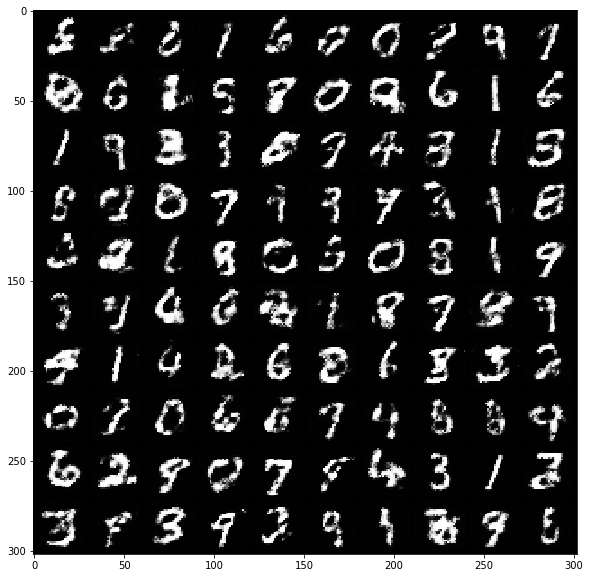

In [ ]:
img_indexes = [0, 4, 9, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.imshow(saved_imgs[i], interpolation='nearest')